# 프로젝트: 자율주행 보조 시스템 만들기

### 실습 목표
---
1. 바운딩 박스(bounding box) 데이터셋을 전처리할 수 있습니다.
2. Object detection 모델을 학습할 수 있습니다.
3. Detection 모델을 활용한 시스템을 만들 수 있습니다.

### 학습 내용
---
1. 자율주행 보조장치
2. RetinaNet
3. keras-retinanet
4. 프로젝트: 자율주행 보조 시스템 만들기

## 목차
[1. 자율주행 시스템 만들기](#1.-자율주행-시스템-만들기)   
[2. 자율주행 시스템 평가하기](#2.-자율주행-시스템-평가하기)  
[Rubric](#Rubric)  
[회고](#회고)


## 1. 자율주행 보조장치

### 1.1 KITTI 데이터셋

#### Library 불러오기

In [27]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

#### KITTI 데이터셋 다운로드

In [2]:
import urllib3
urllib3.disable_warnings()

data_dir = os.path.join(os.getenv("HOME"), "aiffel/object_detection/data")

(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    data_dir=data_dir,
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

#### `tfds.show_examples` 통해 데이터셋 확인

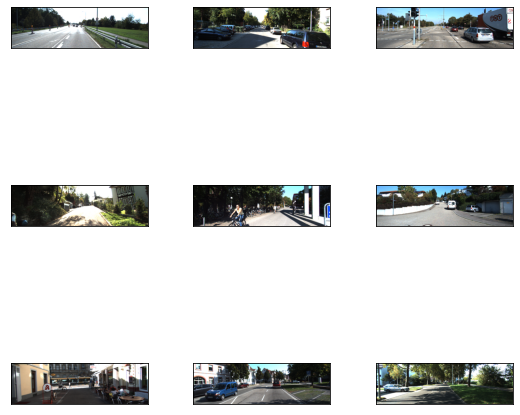

In [3]:
fig = tfds.show_examples(ds_train, ds_info)

#### `ds_info` 통해 데이터셋 정보 확인

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/aiffel/aiffel/object_detection/data/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
     

### 1.2 데이터 직접 확인하기

#### `ds_train.take(1)` 통해 학습에 사용할 데이터 하나의 sample 확인
다음과 같이 학습에 필요한 데이터를 직접 확인해 볼 수 있다.

------Example------
['image', 'image/file_name', 'objects']
------objects------
{'alpha': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-1.65,  1.76, -1.76, -0.32], dtype=float32)>, 'bbox': <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.35032433, 0.5098938 , 0.5684054 , 0.53526145],
       [0.27351353, 0.33089054, 0.55754054, 0.37604576],
       [0.35286486, 0.5809232 , 0.5837838 , 0.60298204],
       [0.3934865 , 0.5996487 , 0.55527025, 0.757835  ]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[1.81, 0.58, 1.7 ],
       [1.73, 0.61, 1.7 ],
       [1.82, 0.53, 0.88],
       [1.41, 1.63, 4.42]], dtype=float32)>, 'location': <tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ 0.78,  1.34, 16.77],
       [-3.06,  1.45, 12.55],
       [ 2.59,  1.25, 15.52],
       [ 5.66,  1.04, 18.12]], dtype=float32)>, 'occluded': <tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 0, 0, 0])>, 'rotation_y': <tf.Tensor: shape=(4,), dtype=flo

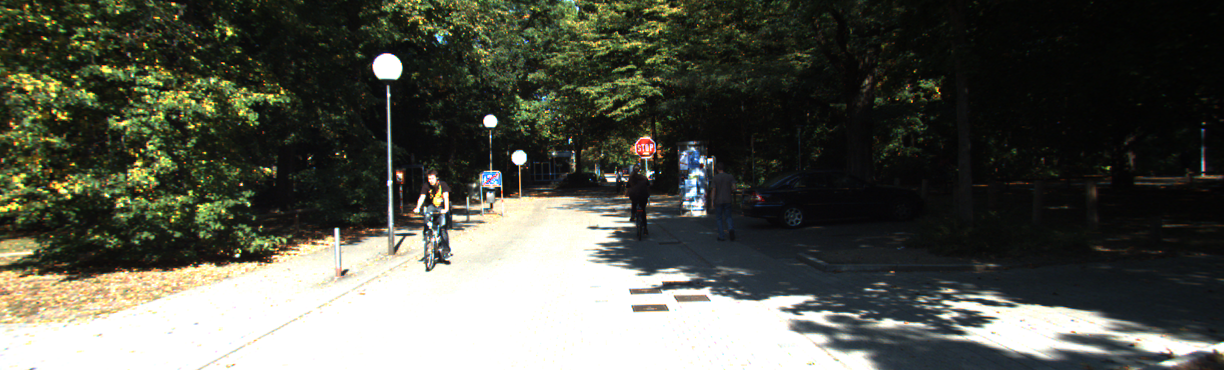

In [5]:
sample = ds_train.take(1)

for example in sample:  
    print('------Example------')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('------objects------')
print(objects)

img = Image.fromarray(image.numpy())
img

#### 이미지 위에 BoundingBox 그려 시각화

width: 1224 height: 370
(4, 4)
[624.11    240.37999 655.16003 159.69   ]
[405.01    268.8     460.28003 163.71   ]
[711.05    239.44    738.05005 153.99998]
[733.97003 224.40999 927.59    164.55   ]
<PIL.Image.Image image mode=RGB size=1224x370 at 0x7FDE783424D0>


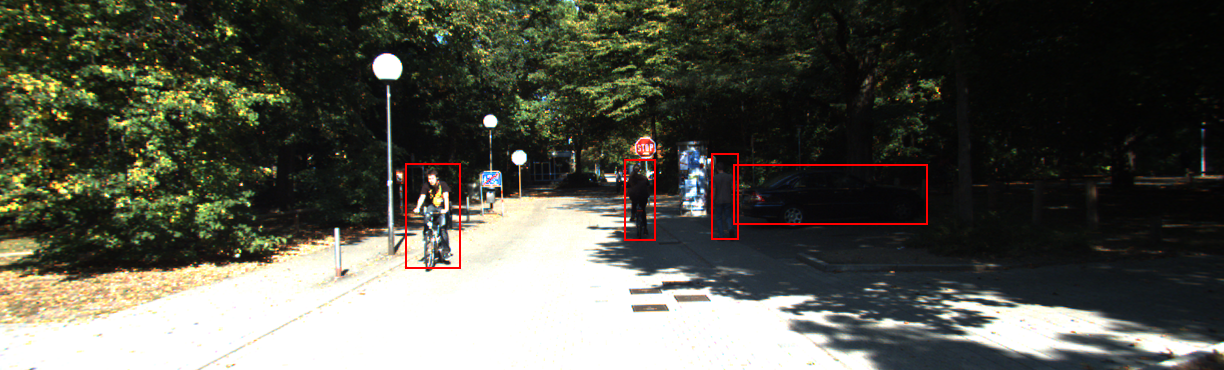

In [6]:
# 이미지 위에 바운딩 박스를 그려 화면에 표시해 주세요.
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print('width:', width, 'height:', height)
    print(object_bbox.shape)
    x_min = object_bbox[:, 1]*width
    x_max = object_bbox[:, 3]*width
    y_min = height - object_bbox[:, 0]*height
    y_max = height - object_bbox[:, 2]*height

    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        print(_rect)
        draw.rectangle(_rect, outline=(255, 0, 0), width=2)
    print(input_image)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 2. RetinaNet

### 2.1 데이터 포맷 변경

### 클래스 및 바운딩 박스 정보 추출

In [7]:
import os
data_dir = os.getenv('HOME') + '/aiffel/object_detection/data'
img_dir = data_dir + '/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# KITTI 데이터셋 ds_train을 파싱해서 dataframe으로 변환하는 parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir, total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        image = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        # tf.dataset의 bbox 좌표가 0과 1 사이로 normalize된 좌표이므로 이를 pixel 좌표로 변환합니다.
        x_min = object_bbox[:, 1] * width
        x_max = object_bbox[:, 3] * width
        y_min = height - object_bbox[:, 2] * height
        y_max = height - object_bbox[:, 0] * height
        
        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path":img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
    
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',', index=False, header=False)

100%|██████████| 6347/6347 [22:56<00:00,  4.61it/s]


#### 테스트 데이터셋에 대해서도 동일하게 `parse_dataset()` 을 적용해 dataframe 생성

In [8]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',', index=False, header=False)

100%|██████████| 711/711 [02:28<00:00,  4.80it/s]


### 클래스 맵핑

In [9]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path):
    class_type_map={
        "car":0,
        "person":1
    }
    with open(path, mode='w',encoding='utf-8')as f:
        for k, v in class_type_map.items():
            f.write(f"{k}, {v}\n")

save_class_format(class_txt_path)

### 2.2 셋팅

#### 미리 설치해 둔 케라스 및 Keras RetinaNet 리포지토리 사용해 RetinaNet 훈련

In [16]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 10 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-10-19 15:38:40.645112: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-19 15:38:40.645178: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-19 15:38:42.129352: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-19 15:38:42.137547: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-19 15:38:42.137686: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcud

#### 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환

In [33]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_10.h5 snapshots/resnet50_csv_10_infer.h5

2021-10-19 22:38:25.731815: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2021-10-19 22:38:25.731862: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-10-19 22:38:27.189360: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-19 22:38:27.197204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0001:00:00.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2021-10-19 22:38:27.197334: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcud

### 2.3 시각화

#### 변환한 모델을 load, 추론 및 시각화

In [49]:
!cd ~/aiffel/object_detection
!cd keras-retinanet && python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.7/keras_retinanet/utils/compute_overlap.cpython-37m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [50]:
!pip install -r requirements.txt
!pip install .

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [51]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_10_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'keras_retinanet'

#### 결과 확인을 위한 함수

In [ ]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path, visualize=True):
    image = read_image_bgr(img_path)
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }
    
    #preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    #process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])
            
            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
        
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()

inference_on_image(model, img_path)

#### 다른 이미지에서 확인

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path)

## 3. 자율주행 보조 시스템 만들기

### 3.1 자율주행 시스템 만들기
---
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.

- 입력으로 이미지 경로를 받습니다.
- 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.
- 조건은 다음과 같습니다.
    - 사람이 한 명 이상 있는 경우
    - 차량의 크기(width or height)가 300px이상인 경우


In [ ]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300, visualize=True):
    image = read_image_bgr(img_path)
    
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
    
    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }
    
    #preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)
    
    #process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    
    # correct for image scale
    boxes /= scale
    
    # display images
    if visualize:
        result = 'Go'
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            w = b[2]-b[0]
            h = b[3]-b[1]
            
            if w >= size_limit or h >= size_limit or label == 1:
                result = 'Stop'
            else:
                result = 'Go'
                
            draw_box(draw, b, color=color_map[label])
            
            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)
        
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()
        
        return result

print(self_drive_assist(img_path))

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_2.png'
self_drive_assist(model=model, img_path=img_path)

## 2. 자율주행 시스템 평가하기
---
아래 `test_system()` 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [ ]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]
    
    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

## Rubric

||**평가 문항**|**상세 기준**|
|:--------|:--------|:--------|
|**1**|KITTI 데이터셋에 대한 분석이 체계적으로 진행되었다.|KITTI 데이터셋 구조와 내용을 파악하고 이를 토대로 필요한 데이터셋 가공을 정상 진행하였다.|
|**2**|RetinaNet 학습이 정상적으로 진행되어 object detection 결과의 시각화까지 진행되었다.|바운딩박스가 정확히 표시된 시각화된 이미지를 생성하였다.|
|**3**|자율주행 Object Detection 테스트시스템 적용결과 만족스러운 정확도 성능을 달성하였다.|테스트 수행결과 90% 이상의 정확도를 보였다.|

## 회고

#### 알게 된 점


#### 느낀 점

